**<h1><center>IDC Big Data Platforms(7 Workers) - Final Project using Spark + ML, 2021</center></h1>**

<u>Date</u>: August 1st, 2021<br>
<u>Authors</u>: Ofer **Gross** (ID 304997067), Yuval **Katz** (ID 311132468), Ofir **Nesher** (ID 204502926)


[Project guidelines](https://docs.google.com/document/d/1wwhifuOkvXhN0ALQWegBhvUYflR2MoXrtYmMAuMdtB8/edit)

[Kaggle competition link](https://www.kaggle.com/c/idc-big-data-platforms-2021-ml-competition)

[Dataset](https://www.kaggle.com/c/idc-big-data-platforms-2021-ml-competition/data)


**Task**:
You should build a classification machine learning model that tries to predict if the fare is lower or higher then $10.<br>
After training the model, given a set of (previously unseen) test data (w/o the fare) you should predict (classify) for each row if the fare is < 10 or >= 10.

# <u>**Imports**</u>

In [1]:
# local python kernel
# !pip3 install anaconda pyspark pandas scikit-learn pycm # Use the pycm package to print the confusion matrix

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
4,application_1627841513647_0005,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
# pyspark kernel
sc.install_pypi_package("pycm")
sc.install_pypi_package("sklearn")
sc.install_pypi_package("requests")
sc.install_pypi_package("pyspark")
sc.install_pypi_package("datetime")
sc.install_pypi_package("os")
sc.install_pypi_package("matplotlib")
sc.install_pypi_package("pandas==0.25.1")
sc.install_pypi_package("numpy==1.15.4")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached pycm-3.1-py2.py3-none-any.whl (63 kB)
  Using cached art-5.2-py2.py3-none-any.whl (571 kB)

  Using cached sklearn-0.0-py2.py3-none-any.whl
  Using cached scikit_learn-0.24.2-cp36-cp36m-manylinux2010_x86_64.whl (22.2 MB)
  Using cached scipy-1.5.4-cp36-cp36m-manylinux1_x86_64.whl (25.9 MB)
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
  Using cached threadpoolctl-2.2.0-py3-none-any.whl (12 kB)

  Using cached requests-2.26.0-py2.py3-none-any.whl (62 kB)
  Using cached urllib3-1.26.6-py2.py3-none-any.whl (138 kB)
  Using cached idna-3.2-py3-none-any.whl (59 kB)
  Using cached certifi-2021.5.30-py2.py3-none-any.whl (145 kB)
  Using cached charset_normalizer-2.0.4-py3-none-any.whl (36 kB)

  Using cached pyspark-3.1.2-py2.py3-none-any.whl
  Using cached py4j-0.10.9-py2.py3-none-any.whl (198 kB)

  Using cached DateTime-4.3-py2.py3-none-any.whl (60 kB)
  Using cached zope.interface-5.4.0-cp36-cp36m-manylinux2010_x86_64.whl (251 kB)


  Using cached matplotlib-3.3.4-c

In [3]:
import numpy as np
import pandas as pd
import json
import requests
from datetime import datetime
import time
import os
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from pyspark.sql.types import IntegerType
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, FloatType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql.functions import to_date, dayofweek, hour, col, avg
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType, FloatType, ByteType, DateType, TimestampType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.sql.window import Window
from pyspark.sql.functions import monotonically_increasing_id, row_number

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---

# <u>**Constants**</u>

In [4]:
# KAGGLE CREDENTIALS
KAGGLE_USERNAME = '###########' # insert yours
KAGGLE_KEY = '###########' # insert yours
KAGGLE_DATASET_PATH = 'idc-big-data-platforms-2021-ml-competition'

S3_BUCKET_URI = 's3://aws-emr-resources-183553851145-us-east-1'

GOOGLE_API_KEY = '###########' # insert yours

# FILENAMES
TRAINING_DATASET_FILENAME = 'idc_train.csv'
TEST_DATASET_FILENAME = 'idc_test.csv'
FINAL_DF_FILENAME = 'final_df.csv'
FINAL_TRAINING_DATASET_FILENAME = 'train_data.csv'
FINAL_VALIDATION_DATASET_FILENAME = 'validation_data.csv'

SPARK_PROJECT_NAME = 'final_project_group_24'

# "Google Drive" path for saving and loading the processed final_df, train_data and validation_data DFs
PROJECT_FOLDER_PATH = '/content/drive/MyDrive/IDC/Big Data/Final project' 

# Specific values for the dataset:
FARE_AMOUNT_THRESHOLD = 10 # The classification ML model tries to predict if the fare is lower or higher then ${FARE_PRICE_THRESHOLD}
MIN_PASSENGER_COUNT = MIN_FARE_AMOUNT = MIN_RIDE_LENGTH = 1
MAX_PASSENGER_COUNT = 10
MAX_FARE_AMOUNT = 100
MAX_RIDE_LENGTH = 100 # (maximum of 100 KM for a ride)

COORDINATES_COLUMNS = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
WEEKEND = ['Saturday', 'Sunday']
JFK_COORDINATES = {'latitude': 40.6413, 'longitude': -73.7781}
LaGuardia_COORDINATES = {'latitude': 40.7769, 'longitude': -73.8740}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---

# <u>**Kaggle**</u>

Uncomment with python kernel (local run)

In [5]:
# !pip install kaggle

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# token = '{'f'"username": "{KAGGLE_USERNAME}", "key": "{KAGGLE_KEY}"''}'

# # with open('kaggle.json', 'w') as f:
# #     f.write(token)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# t = time.time()

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c {KAGGLE_DATASET_PATH}

# print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# # unzip dataset files
# t = time.time()

# if os.path.exists(TRAINING_DATASET_FILENAME) == False:
#     !unzip {TRAINING_DATASET_FILENAME}.zip
#     !rm {TRAINING_DATASET_FILENAME}.zip

# if os.path.exists(TEST_DATASET_FILENAME) == False:
#     !unzip {TEST_DATASET_FILENAME}.zip
#     !rm {TEST_DATASET_FILENAME}.zip

# print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---

# <u>**Create Spark App**</u>

In [9]:
# PySpark applications start with initializing SparkSession which is the entry point of PySpark
spark = SparkSession.builder.appName(SPARK_PROJECT_NAME).getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---

# <u>**Load data**</u>

In [10]:
t = time.time()

#read a CSV file from S3 bucket into a Spark dataframe with an explicit scheme, create schema and use it to read the file
train_schema = StructType([
    StructField("key", IntegerType()),
    StructField("fare_amount", FloatType()),
    StructField("pickup_datetime", TimestampType()), 
    StructField("pickup_longitude", FloatType()),
    StructField("pickup_latitude", FloatType()),
    StructField("dropoff_longitude", FloatType()),
    StructField("dropoff_latitude", FloatType()),
    StructField("passenger_count", ByteType())
])

train_df = spark.read.format("csv").option("header", "true").schema(train_schema).option("TimeStampFormat", "yyyy-mm-dd hh:mm:ss").load(f'{S3_BUCKET_URI}/{TRAINING_DATASET_FILENAME}')

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 2.54140567779541 s

In [11]:
train_df.printSchema()
train_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- key: integer (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- pickup_longitude: float (nullable = true)
 |-- pickup_latitude: float (nullable = true)
 |-- dropoff_longitude: float (nullable = true)
 |-- dropoff_latitude: float (nullable = true)
 |-- passenger_count: byte (nullable = true)

+---+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+---+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|  1|        8.5|2010-01-30 19:27:00|       -73.96539|      40.768574|       -73.998184|       40.761074|              1|
|  2|      35.47|2010-01-10 20:02:03|      -73.967354|      40.769295|       -73.967285|       40.802975|              1|
|  3|        6.1|2011-0

---

# <u>**Preprocessing**</u>

## <u>**Handling the data**</u>


Handle missing or incorrect data, e.g. eliminate negative or zero fares, for example replace missing values by the average or median value or delete them. Also read the pickup time in a way that it can be used. Use imputation where applicable.


###### <u>**Cleaning the data**</u>

In [12]:
t = time.time()

# Eliminate negative or zero fares and passengers, and remove too many passengers (more than MAX_PASSENGER_COUNT)
train_df = train_df.filter((train_df.fare_amount >= MIN_FARE_AMOUNT) & (train_df.passenger_count >= MIN_PASSENGER_COUNT) & (train_df.passenger_count <= MAX_PASSENGER_COUNT))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.37298154830932617 s

In [13]:
t = time.time()

# Eliminate rows with coordinates with value zero
train_df = train_df.filter((train_df.pickup_longitude != 0) & (train_df.pickup_latitude != 0) & (train_df.dropoff_longitude != 0) & (train_df.dropoff_latitude != 0))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.03942584991455078 s

###### <u>**Setting values in range for max fare amount**</u>

In [14]:
t = time.time()

train_df = train_df.withColumn('fare_amount', when(col('fare_amount') < MAX_FARE_AMOUNT, col('fare_amount')).otherwise(MAX_FARE_AMOUNT))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.0766139030456543 s

###### <u>**Filtering legal locations**</u>

In [15]:
t = time.time()

## legal locations:
location_conditions = (col("pickup_longitude") != 0) & (col("pickup_latitude") != 0) & \
                      (col("dropoff_longitude") != 0) & (col("dropoff_latitude") != 0) & \
                      ((col("pickup_longitude") != col("dropoff_longitude")) | (col("pickup_latitude") != col("dropoff_latitude"))) & \
                      (col("pickup_longitude") > -180) & (col("pickup_longitude") < 180) & \
                      (col("pickup_latitude") > -90) & (col("pickup_latitude") < 90) & \
                      (col("dropoff_longitude") > -180) & (col("dropoff_longitude") < 180) & \
                      (col("dropoff_latitude") > -90) & (col("dropoff_latitude") < 90)

train_df = train_df.filter(location_conditions)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.17694520950317383 s

###### <u>**Removing NULLs and NANs**</u>

In [16]:
# uncomment to show the number of NaN/null values per column
# train_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in train_df.columns]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
# remove missing values (although there aren't any, we keep it for future datasets)
t = time.time()

train_df.na.drop(how="any").show(truncate=False)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|key|fare_amount|pickup_datetime    |pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+---+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|1  |8.5        |2010-01-30 19:27:00|-73.96539       |40.768574      |-73.998184       |40.761074       |1              |
|2  |35.47      |2010-01-10 20:02:03|-73.967354      |40.769295      |-73.967285       |40.802975       |1              |
|3  |6.1        |2011-01-13 13:24:00|-73.96884       |40.758278      |-73.961395       |40.768566       |1              |
|4  |9.7        |2011-01-11 19:45:14|-73.98218       |40.774796      |-73.95431        |40.78315        |1              |
|5  |7.7        |2011-01-03 13:16:02|-73.9778        |40.74228       |-73.998634       |40.734917       |1              |
|6  |57.33      |2013-01

###### <u>**Casting "passenger_count" column to integer values**</u>

In [18]:
t = time.time()

train_df = train_df.withColumn("passenger_count", train_df["passenger_count"].cast(IntegerType()))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.013888120651245117 s

###### <u>**Casting coordinates columns ("pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude") to floats**</u>

In [19]:
t = time.time()

for col_name in COORDINATES_COLUMNS:
    train_df = train_df.withColumn(col_name, col(col_name).cast('float'))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.26501917839050293 s

## <u>**Adding "high_fare" column**</u>


Create a new boolean column “high_fare” for the training set from the fare amount (i.e. if fair is < 10 or >= 10). Use it as the label (dependent variable) for your classification model. Ignore the fare amount in the rest of this project, unless you want to try a regression model as an extra challenge:


In [20]:
t = time.time()

train_df = train_df.withColumn(
    'high_fare',
    when((col('fare_amount') < FARE_AMOUNT_THRESHOLD), 0).otherwise(1)
)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.08125829696655273 s

---

# <u>**Feature Engineering**</u>

For example, create a ride_length feature that calculates the straight line distance of the ride. Also consider how to create useful features from the pickup time, such as day of week, hour of the day etc (search e.g. [here](https://spark.apache.org/docs/latest/api/java/index.html?org/apache/spark/sql/functions.html)).

### 1.   Convert UTC time to NYC time -> "local_pickup_datetime" feature

In [21]:
t = time.time()

# http://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.from_utc_timestamp.html
train_df = train_df.withColumn('local_pickup_datetime', from_utc_timestamp("pickup_datetime", "America/New_York"))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.011722803115844727 s

### 2.   Adding "pickup_hour" feature

In [22]:
t = time.time()

train_df = train_df.withColumn("pickup_hour", hour(col("local_pickup_datetime")))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.014793872833251953 s

### 3.   Adding "day" feature

In [23]:
t = time.time()

train_df = train_df.withColumn("day", date_format(col("local_pickup_datetime"), "EEEE"))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.01300501823425293 s

### 4. Adding "holiday" feature

We are assuming that the ride fare during holiday/weekend is higher than business days.

In [24]:
t = time.time()

max_date = datetime.now()
min_date = datetime.strptime("2008-01-01", '%Y-%m-%d') # Uber was founded in ~2008, so we assume there is no earlier data

cal = calendar()
holidays = cal.holidays(start=min_date, end=max_date)
holidays = [date.strftime('%Y-%m-%d') for date in holidays]
# print(len(holidays))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.05564713478088379 s

In [25]:
t = time.time()

train_df = train_df.withColumn("holiday_or_weekend", when(date_format(col("local_pickup_datetime"), 'yyyy-MM-dd').isin(holidays) , 1).when(col('day').isin(WEEKEND), 1).otherwise(0))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.7593319416046143 s

### 5. Adding feature: "fare_length" (distance in KM)

In [26]:
def haversine(lon1, lat1, lon2, lat2):
    '''
    Haversine formula
    https://en.wikipedia.org/wiki/Haversine_formula
    '''
    r = 6373.0 # approximate radius of earth in kilometers. Use 3956 for miles
    dLat = F.radians(lat2 - lat1)
    dLon = F.radians(lon2 - lon1)
    lat1 = F.radians(lat1)
    lat2 = F.radians(lat2)
    a = F.sin(dLat/2) ** 2 + F.cos(lat1) * F.cos(lat2) * F.sin(dLon/2) **2
    c = 2*F.asin(F.sqrt(a))

    return c * r

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
t = time.time()

train_df = train_df.withColumn("ride_length", haversine(col("pickup_longitude"), col("pickup_latitude"), col("dropoff_longitude"), col("dropoff_latitude")))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.16010069847106934 s

### 6. Check if ride to/from JFK airport or LaGuardia

In [28]:
def is_airport_ride(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude,
                    test_JFK_longitude, test_JFK_latitude, test_LaGuardia_longitude, test_LaGuardia_latitude):
    '''
    Check if ride started or ended within a given radius (in KM) from the local airport.
    Here, we use hardcoded coordinates values for JFK airport in NYC,
    and we assume that it affects the ride's fare (probably "high_fare" == 1)

    radius: should be given as a float in kilometers
    '''

    radius = 1.00

    JFK_pickup_location = haversine(pickup_longitude, pickup_latitude, test_JFK_longitude, test_JFK_latitude)
    JFK_dropoff_location = haversine(dropoff_longitude, dropoff_latitude, test_JFK_longitude, test_JFK_latitude)

    LaGuardia_pickup_location = haversine(pickup_longitude, pickup_latitude, test_JFK_longitude, test_JFK_latitude)
    LaGuardia_dropoff_location = haversine(dropoff_longitude, dropoff_latitude, test_JFK_longitude, test_JFK_latitude)
    
    JFK_res = (JFK_pickup_location <= radius).cast('int') + (JFK_dropoff_location <= radius).cast('int')
    LaGuardia_res = (LaGuardia_pickup_location <= radius).cast('int') + (LaGuardia_dropoff_location <= radius).cast('int')
    
    res = JFK_res + LaGuardia_res

    return res

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
t = time.time()

train_df = train_df.withColumn('test_JFK_longitude', lit(JFK_COORDINATES['longitude']))
train_df = train_df.withColumn('test_JFK_latitude', lit(JFK_COORDINATES['latitude']))

train_df = train_df.withColumn('test_LaGuardia_longitude', lit(LaGuardia_COORDINATES['longitude']))
train_df = train_df.withColumn('test_LaGuardia_latitude', lit(LaGuardia_COORDINATES['latitude']))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.03323626518249512 s

In [30]:
t = time.time()

train_df = train_df.withColumn("is_airport_ride", is_airport_ride(col("pickup_longitude"), col("pickup_latitude"), col("dropoff_longitude"), col("dropoff_latitude"),
                                                                  col("test_JFK_longitude"), col("test_JFK_latitude"), col("test_LaGuardia_longitude"), col("test_LaGuardia_latitude")
                                                                 )).drop('test_JFK_longitude', 'test_JFK_latitude', 'test_LaGuardia_longitude', 'test_LaGuardia_latitude')
train_df = train_df.withColumn("is_airport_ride", when(col('is_airport_ride') >= 1, 1).otherwise(0))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.411083459854126 s

In [31]:
# See how many rides are to/from the airports
# train_df.filter(train_df.is_airport_ride == 1).count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 7. Adding features "google_maps_estimate_distance_km" & "google_maps_estimate_duration_min"

Estimate the ride_length (distance and time) from Google Maps, for better predictions.<br>
<i>Since it was expensive (5$ per 1000 entries) and we ran out of budget quickly, we decided to put this feature on hold (in a comment), but to keep the code for future use.</i>

In [32]:
# !pip install googlemaps
# !pip install polyline

# import googlemaps

def get_estimation(origin_latitude, origin_longitude, destination_latitude, destination_longitude, title):
    '''
    Get estimated time and length of ride using the the ride's coordinates, using Google Maps
    '''

    gmaps = googlemaps.Client(key=GOOGLE_API_KEY)
    estimate = gmaps.distance_matrix([str(origin_latitude) + " " + str(origin_longitude)], [str(destination_latitude) + " " + str(destination_longitude)], mode='driving')['rows'][0]['elements'][0]
    
    if title == "google_maps_estimate_distance_km":
        variable_estimate = estimate['distance']['value'] / 1000
    else:
        variable_estimate = estimate['duration']['value'] / 60

    return variable_estimate

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
# Cancelled since API is very expensicve
# get_estimation_func = udf(lambda a,b,c,d,e: get_estimation(a,b,c,d,e), StringType())
# train_df = train_df.withColumn('google_maps_estimate_distance_km', get_estimation_func(train_df.pickup_latitude, train_df.pickup_longitude, train_df.dropoff_latitude, train_df.dropoff_longitude, lit("google_maps_estimate_distance_km")))
# train_df = train_df.withColumn('google_maps_estimate_duration_min', get_estimation_func(train_df.pickup_latitude, train_df.pickup_longitude, train_df.dropoff_latitude, train_df.dropoff_longitude, lit("google_maps_estimate_duration_min")))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Eliminate unreasonable (negative/zero/very-large ride lengths)

In [34]:
t = time.time()

train_df = train_df.filter((train_df.ride_length >= MIN_RIDE_LENGTH) & (train_df.ride_length <= MAX_RIDE_LENGTH))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.015146493911743164 s

In [35]:
train_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+---------+---------------------+-----------+---------+------------------+------------------+---------------+
|key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|high_fare|local_pickup_datetime|pickup_hour|      day|holiday_or_weekend|       ride_length|is_airport_ride|
+---+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+---------+---------------------+-----------+---------+------------------+------------------+---------------+
|  1|        8.5|2010-01-30 19:27:00|       -73.96539|      40.768574|       -73.998184|       40.761074|              1|        0|  2010-01-30 14:27:00|         14| Saturday|                 1|2.8856935406747497|              0|
|  2|      35.47|2010-01-10 20:02:03|      -73.967354|      40.769295|       -73

---

# <u>**Visualization**</u>

Use plot or plotly with a Pandas dataframe (or another plotting package) to create the following plots (with a sample of 10,000):
1.   Distribution of ride fairs.
2.   Ride fare vs. ride length.
3.   Average ride length per pickup hour of the day (x-axis = 24 hours).

In [36]:
# get 10K data entries into a DF
sample_size = 10000
small_df = train_df.limit(sample_size)
small_pd = small_df.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Results can be seen [here](https://docs.google.com/document/d/1PgItufUSFI7U0r7QNizOjVTAqobejBYDhPj__k3kwYw/edit?usp=sharing)**

In [37]:
# import matplotlib.pyplot as plt

# # 1. Distribution of ride fairs
# small_df.fare_amount.hist(bins=90, edgecolor='black', color='red', figsize=(12,7))
# plt.title('Distribution of ride fairs', fontsize=17)
# plt.xlabel('fare_amount ($ US)', fontsize=15)
# plt.ylabel('Count', fontsize=15)
# plt.show()
# print('\n')

# # 2. Ride fare vs. ride length
# small_df.plot(kind='scatter', x='fare_amount', y='ride_length', marker='o', alpha=0.4, color='green', figsize=(12,7))
# plt.title('Ride fare vs. Ride length - Scatter Plot', fontsize=17)
# plt.xlabel('fare_amount ($ US)', fontsize=15)
# plt.ylabel('ride_length (KM)', fontsize=15)
# plt.show()
# print('\n')

# # 3. Average ride length per pickup hour of the day (x-axis = 24 hours)
# small_df.groupby(['pickup_hour'])['ride_length'].mean().plot.bar(color='blue', figsize=(12,7))
# plt.title('Average ride length per pick up time hour of the day', fontsize=17)
# plt.xlabel('pickup_hour', fontsize=15)
# plt.ylabel('Average ride length (KM)', fontsize=15)
# plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Plotly is not supported with PySpark Kernel on EMR, so we attach our results as images below. <br>
If you run the notebook locally, you can comment-out the cells below and use the library on your own data.**

In [38]:
# !pip install chart-studio
# sc.install_pypi_package("chart-studio")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
# from chart_studio.plotly import plot, iplot
# import plotly.graph_objects as go
# import plotly.express as px

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 1.   Distribution of ride fairs

In [40]:
# fare_amount_list = np.array(small_df.select('fare_amount').collect()).reshape(-1)
# fig = go.Figure(data=[go.Histogram(x=fare_amount_list)])

# fig.update_layout(
#     title={
#         'text':"Distribution of ride fairs",
#         'y':0.9,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor':'top'
#         },
#     xaxis_title="fare_amount ($ US)",
#     yaxis_title="Count")

# fig.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

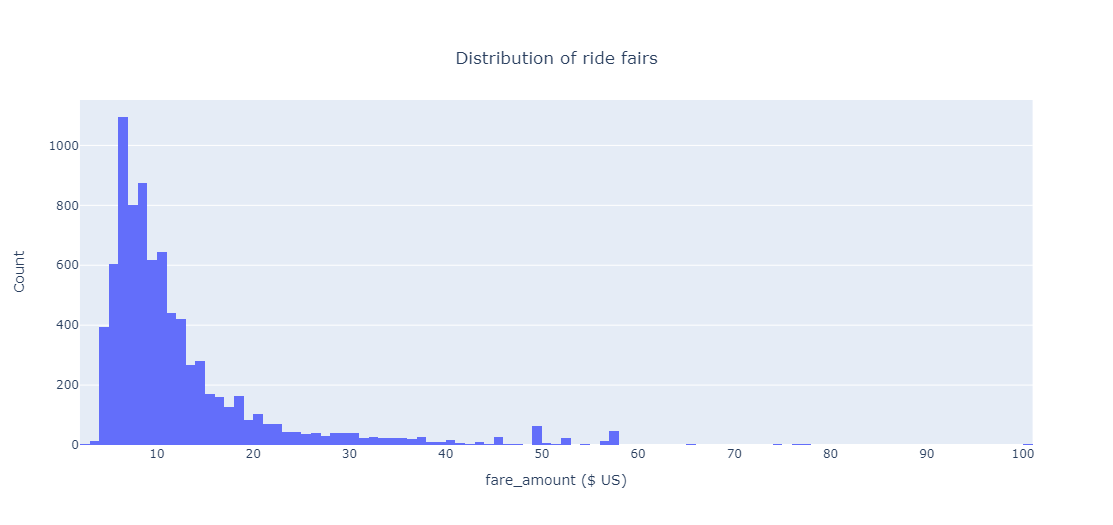

According to these 10K entries, we see that the distribution is left-skewed, meaning, the majority of rides fares are less than 20$.

### 2.   Ride fare vs. ride length

In [41]:
# ride_length_list = np.array(small_df.select('ride_length').collect()).reshape(-1)
# fig = go.Figure(data=go.Scatter(x=fare_amount_list, y=ride_length_list, mode='markers'))

# fig.update_layout(
#     title={
#         'text':"Ride fare vs. Ride length - Scatter Plot",
#         'y':0.9,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top'
#         },
#     xaxis_title="fare_amount ($ US)",
#     yaxis_title="ride_length (KM)"
# )

# fig.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

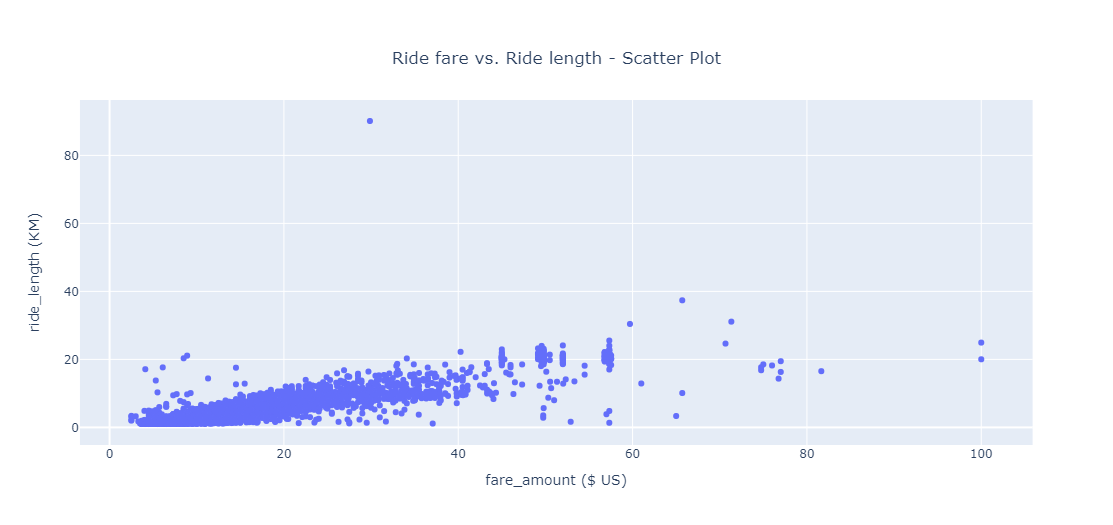

It seems like there is some positive correlation between the fare cost and the length of the rides - this makes sense of course!
We spot some outliers in the data:
1.   30\$ for a 90KM ride
2.   50\$ for a 97KM ride
3.   100\$ for 20-24KM rides

### 3.   Average ride length per pickup hour of the day (x-axis = 24 hours)

In [42]:
# fig = px.histogram(small_pd, x="pickup_hour", y="ride_length", histfunc="avg", title="Average ride length (in KM) per pick up time hour of the day (x-axis = 24 hours)")
# fig.update_traces(xbins_size="M1")
# fig.update_xaxes(showgrid=True)
# fig.update_layout(bargap=0.1)
# fig.add_trace(go.Scatter(mode="markers", x=small_pd["pickup_hour"], y=small_pd["ride_length"], name="daily"))
# fig.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

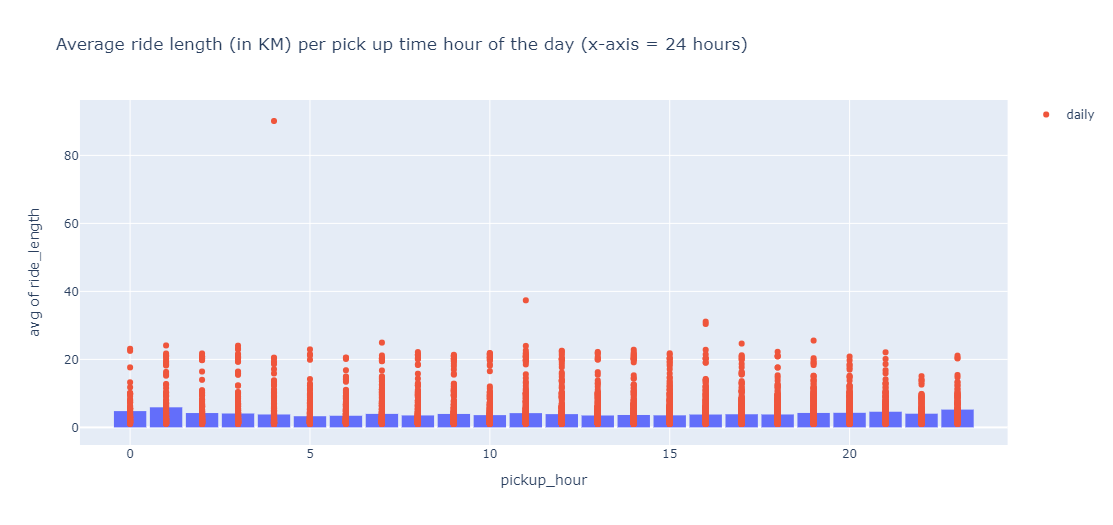

We can see that the average ride length is largest at 1AM (\~5.9KM) and smallest at 6AM (\~3.2KM).

In [43]:
t = time.time()

total_average_ride_length = np.mean(np.array(small_df.select('ride_length').collect()).reshape(-1).astype(np.float))
print(f'The total average ride length is {total_average_ride_length} KM')

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The total average ride length is 3.844665684523211 KM
Running time 1.0497324466705322 s

---

# <u>**Get final vector for model**</u>

In [44]:
# Here, we decide which features to keep for model's training

t = time.time()

FINAL_COLUMNS = ["high_fare", "passenger_count", "ride_length", 
                 "is_airport_ride",
                 "pickup_hour", "holiday_or_weekend"]

final_df = train_df.select(*FINAL_COLUMNS)

feature_cols = final_df.columns
feature_cols.remove("high_fare")

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.024101972579956055 s

In [45]:
t = time.time()

feature_cols = final_df.columns
feature_cols.remove("high_fare")

# import the vector assembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Now let us use the transform method to transform our dataset
final_df = assembler.transform(final_df)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.18874406814575195 s

# <u>**Scaling the data**</u>

In [46]:
t = time.time()

minmax_scaler = MinMaxScaler().setInputCol("features").setOutputCol("scaled_features")
minmax_model = minmax_scaler.fit(final_df) 
final_df = minmax_model.transform(final_df)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 27.214700937271118 s

# <u>**Splitting the data to training and validation sets**</u>

Train your models using 80% of the training set, keeping 20% aside for validation (or cross-validation). Then test the models on the validation set. Output the model results - print the confusion matrix.

In [47]:
t = time.time()

train_data, validation_data = final_df.randomSplit([0.8, 0.2], seed=10)
# train_data = final_df

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.023552417755126953 s

# <u>**Save final_df, train_data & validation_data to csv files in Google Drive (optional)**</u>

Can be used when running locally with pyhton kernel

In [48]:
# from google.colab import drive
# drive.mount('/content/drive')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
# # Write the DataFrame to CSV file.
# with open(f'{PROJECT_FOLDER_PATH}/{FINAL_DF_FILENAME}', 'w') as f:
#     final_df.toPandas().to_csv(f, header=True, index=False)

# with open(f'{PROJECT_FOLDER_PATH}/{FINAL_TRAINING_DATASET_FILENAME}', 'w') as f:
#     train_data.toPandas().to_csv(f, header=True, index=False)

# with open(f'{PROJECT_FOLDER_PATH}/{FINAL_VALIDATION_DATASET_FILENAME}', 'w') as f:
#     validation_data.toPandas().to_csv(f, header=True, index=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# <u>**Load final_df, train_data & validation_data from csv files saved in Google Drive (optional)**</u>

Run the following sections before moving forward:
- Imports
- Constants
- Create Spark App

In [50]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
# if os.path.exists(f'{PROJECT_FOLDER_PATH}/{FINAL_DF_FILENAME}') == True:
#     final_df = spark.read.option('header',True).csv(f'{PROJECT_FOLDER_PATH}/{FINAL_DF_FILENAME}')

# if os.path.exists(f'{PROJECT_FOLDER_PATH}/{FINAL_TRAINING_DATASET_FILENAME}') == True:
#     train_data = spark.read.option('header',True).csv(f'{PROJECT_FOLDER_PATH}/{FINAL_TRAINING_DATASET_FILENAME}')

# if os.path.exists(f'{PROJECT_FOLDER_PATH}/{FINAL_VALIDATION_DATASET_FILENAME}') == True:
#     validation_data = spark.read.option('header',True).csv(f'{PROJECT_FOLDER_PATH}/{FINAL_VALIDATION_DATASET_FILENAME}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
# validation_data.show() # if prints a DF, then you are good to go to the rest of the notebook below this cell

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---

# <u>**Training ML Models**</u>

Try logistic regression first, decision tree and then either a random forest or a gradient-boosted tree or both.  Use scaling where necessary. You need to achieve AUC (area under the curve) of at least 0.8 and hopefully better.

In [53]:
t = time.time()


# give different weight for each class
dataset_size = float(train_data.select("high_fare").count())
num_ones = train_data.select("high_fare").where('high_fare == 1').count()
percent_ones = (float(num_ones) / float(dataset_size))
print(f'The percent of "high_fare" == 1 in the train data is: {percent_ones}')

train_data = train_data.withColumn("classWeights", when(train_data.high_fare == 1, 1-percent_ones).otherwise(percent_ones))


print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The percent of "high_fare" == 1 in the train data is: 0.4562865434188817
Running time 112.15262460708618 s

In [54]:
train_data.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+---------------+------------------+---------------+-----------+------------------+--------------------+--------------------+------------------+
|high_fare|passenger_count|       ride_length|is_airport_ride|pickup_hour|holiday_or_weekend|            features|     scaled_features|      classWeights|
+---------+---------------+------------------+---------------+-----------+------------------+--------------------+--------------------+------------------+
|        0|              1| 1.000000713499224|              0|          4|                 1|[1.0,1.0000007134...|[0.0,6.9312097341...|0.4562865434188817|
|        0|              1|1.0000050503885924|              0|         16|                 1|[1.0,1.0000050503...|[0.0,5.0740447293...|0.4562865434188817|
|        0|              1| 1.000034053558028|              0|          4|                 0|[1.0,1.0000340535...|[0.0,3.4371696382...|0.4562865434188817|
|        0|              1| 1.000038061653178|              0|        

In [55]:
def confusion_matrix(predict_df, actual_df, assign_id = True):
    y_actual = actual_df.select(["high_fare"])
    y_actual = y_actual.withColumn("id", monotonically_increasing_id())

    y_pred = predict_df.select(["prediction"])
    y_pred = y_pred.withColumn("id", monotonically_increasing_id())

    if not assign_id:
        y_pred = ensamble_pred_df.select(["id", "prediction"])

    result_df = y_actual.join(y_pred, "id", "outer").drop("id")
    actual0_pred0 = result_df.filter((col("high_fare") == 0) & (col("prediction") == 0)).count()
    actual0_pred1 = result_df.filter((col("high_fare") == 0) & (col("prediction") == 1)).count()
    actual1_pred0 = result_df.filter((col("high_fare") == 1) & (col("prediction") == 0)).count()
    actual1_pred1 = result_df.filter((col("high_fare") == 1) & (col("prediction") == 1)).count()
    confusion_df = pd.DataFrame([[actual0_pred0, actual0_pred1], [actual1_pred0, actual1_pred1]] ,index = ["0", "1"], columns = ["0", "1"])
    confusion_df.index.name = "Actual"
    confusion_df.columns.name = "Predicted"
    
    print(confusion_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
t = time.time()

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="high_fare")

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.010081768035888672 s

## <u>**Train a Multi Layer Perceptron  model**</u>

In [57]:
t = time.time()

layers = [5, 5, 2]
trainer = MultilayerPerceptronClassifier(labelCol="high_fare", featuresCol="scaled_features", maxIter=100, layers=layers, blockSize=256, seed=1234)
# train the model
mlp_model = trainer.fit(train_data)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 157.4564085006714 s

In [58]:
t = time.time()

predict_train_mlp = mlp_model.transform(train_data)
predict_validation_mlp = mlp_model.transform(validation_data)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.09910941123962402 s

## <u>**Test a Multi Layer Perceptron model**</u>

In [59]:
t = time.time()

print(f"The area under ROC for train set is {evaluator.evaluate(predict_train_mlp)}")
print(f"The area under ROC for validation set is {evaluator.evaluate(predict_validation_mlp)}")

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The area under ROC for train set is 0.9201291812672318
The area under ROC for validation set is 0.9201340433483045
Running time 139.20978903770447 s

In [60]:
t = time.time()

confusion_matrix(predict_validation_mlp, validation_data)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Predicted        0        1
Actual                     
0          1611596   157229
1           332142  1154889
Running time 457.5036389827728 s

## <u>**Training a Logistic Regression model**</u>

In [61]:
t = time.time()

lr = LogisticRegression(labelCol="high_fare", featuresCol="scaled_features", weightCol="classWeights")
lr_model = lr.fit(train_data)
predict_train_lr = lr_model.transform(train_data)
predict_validation_lr = lr_model.transform(validation_data)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 64.40852689743042 s

## <u>**Testing a Logistic Regression model**</u>

In [62]:
t = time.time()

print(f"The area under ROC for train set is {evaluator.evaluate(predict_train_lr)}")
print(f"The area under ROC for validation set is {evaluator.evaluate(predict_validation_lr)}")

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The area under ROC for train set is 0.9210062057305165
The area under ROC for validation set is 0.9209531997528891
Running time 138.8931200504303 s

In [63]:
t = time.time()

confusion_matrix(predict_validation_lr, validation_data)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Predicted        0        1
Actual                     
0          1578691   190134
1           302752  1184279
Running time 455.90216994285583 s

## <u>**Training a Decision Tree model**</u>

In [64]:
t = time.time()

dt = DecisionTreeClassifier(labelCol="high_fare", featuresCol="scaled_features") # weightCol="classWeights" was not supported with pyspark kernel and Decision Trees
dt_model = dt.fit(train_data)
predict_train_dt = dt_model.transform(train_data)
predict_validation_dt = dt_model.transform(validation_data)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 262.07133054733276 s

## <u>**Testing a Decision Tree model**</u>

In [65]:
t = time.time()

print(f"The area under ROC for train set is {evaluator.evaluate(predict_train_dt)}")
print(f"The area under ROC for validation set is {evaluator.evaluate(predict_validation_dt)}")

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The area under ROC for train set is 0.7662149889702827
The area under ROC for validation set is 0.7664677636401444
Running time 116.81920599937439 s

In [66]:
t = time.time()

confusion_matrix(predict_validation_dt, validation_data)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Predicted        0        1
Actual                     
0          1568701   200124
1           286189  1200842
Running time 455.8094778060913 s

## <u>**Training a Decision Gradient-Boosted Tree model**</u>

In [67]:
t = time.time()

gbt = GBTClassifier(labelCol="high_fare", featuresCol="scaled_features") #weightCol="classWeights" was not supported with pyspark kernel and Decision Trees
gbt_model = gbt.fit(train_data)
predict_train_gbt = gbt_model.transform(train_data)
predict_validation_gbt = gbt_model.transform(validation_data)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 237.50707721710205 s

## <u>**Testing Decision Gradient-Boosted Tree model**</u>

In [68]:
t = time.time()

print(f"The area under ROC for train set is {evaluator.evaluate(predict_train_gbt)}")
print(f"The area under ROC for validation set is {evaluator.evaluate(predict_validation_gbt)}")

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The area under ROC for train set is 0.9242946741574265
The area under ROC for validation set is 0.9242843249236368
Running time 118.47546219825745 s

In [69]:
t = time.time()

confusion_matrix(predict_validation_gbt, validation_data)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Predicted        0        1
Actual                     
0          1572746   196079
1           289824  1197207
Running time 460.44872188568115 s

## <u>**Ensemble Models**</u>

We ended up not using this model but we're leaving the code for future use

In [70]:
# t = time.time()


# y_pred_lr = predict_validation_lr
# y_pred_lr = y_pred_lr.withColumn("id", monotonically_increasing_id())
# y_pred_lr = y_pred_lr.withColumnRenamed("prediction", "pred_lr")

# y_pred_dt = predict_validation_dt.select(["prediction"])
# y_pred_dt = y_pred_dt.withColumn("id", monotonically_increasing_id())
# y_pred_dt = y_pred_dt.withColumnRenamed("prediction", "pred_dt")

# y_pred_gbt = predict_validation_gbt.select(["prediction"])
# y_pred_gbt = y_pred_gbt.withColumn("id", monotonically_increasing_id())
# y_pred_gbt = y_pred_gbt.withColumnRenamed("prediction", "pred_gbt")

# ensamble_pred_df = y_pred_lr.join(y_pred_dt, "id", "outer")
# ensamble_pred_df = ensamble_pred_df.join(y_pred_gbt, "id", "outer")

# ensamble_pred_df = ensamble_pred_df.withColumn("majority", ((ensamble_pred_df['pred_lr'] + 
#                                                             ensamble_pred_df['pred_dt'] + 
#                                                             ensamble_pred_df['pred_gbt']) >=2).cast('float'))

# ensamble_pred_df = ensamble_pred_df.drop("pred_lr", "pred_dt", "pred_gbt")
# ensamble_pred_df = ensamble_pred_df.withColumnRenamed("majority", "prediction")

# ensamble_pred_df.show()


# print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [71]:
# t = time.time()

# print(f"The area under ROC for validation set is {evaluator.evaluate(ensamble_pred_df)}")

# print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
# t = time.time()

# confusion_matrix(ensamble_pred_df, validation_data, assign_id = False)

# print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# <u>**TEST data**</u>

In [73]:
t = time.time()

# Read a CSV file from S3 bucket into a Spark dataframe with an explicit schema
# the Test data does not have fare_amount
test_schema = StructType([
    StructField("key", IntegerType()),
    StructField("pickup_datetime", TimestampType()), # Will later extract date and time
    StructField("pickup_longitude", FloatType()),
    StructField("pickup_latitude", FloatType()),
    StructField("dropoff_longitude", FloatType()),
    StructField("dropoff_latitude", FloatType()),
    StructField("passenger_count", ByteType())
])

test_df = spark.read.format("csv").option("header", "true").schema(test_schema).option("TimeStampFormat", "yyyy-mm-dd hh:mm:ss").load(f'{S3_BUCKET_URI}/{TEST_DATASET_FILENAME}')

print('Running time', time.time() - t)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.1491546630859375

In [74]:
test_df.printSchema()
test_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- key: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- pickup_longitude: float (nullable = true)
 |-- pickup_latitude: float (nullable = true)
 |-- dropoff_longitude: float (nullable = true)
 |-- dropoff_latitude: float (nullable = true)
 |-- passenger_count: byte (nullable = true)

+--------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|     key|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+--------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|19990001|2012-01-31 07:04:14|       -73.94636|      40.792088|        -73.96618|       40.764984|              2|
|19990002|2015-01-27 20:51:29|       -73.97137|        40.7604|       -73.995346|       40.744392|              6|
|19990003|2015-01-18 16:41:16|       -73.96013|       40.76694|        -73.95677|        40.77497|  

### <u>**Converting bad coordinates values to their mean**</u>

In [75]:
# mean_pickup_longitude

t = time.time()


pickup_longitude_location_conditions = (col("pickup_longitude") != 0) & \
                      ((col("pickup_longitude") != col("dropoff_longitude")) | (col("pickup_latitude") != col("dropoff_latitude"))) & \
                      (col("pickup_longitude") > -180) & (col("pickup_longitude") < 180)

pickup_longitude_df = test_df.filter(pickup_longitude_location_conditions)

mean_pickup_longitude = pickup_longitude_df.agg(F.mean('pickup_longitude').alias('mean'))

mean_pickup_longitude = mean_pickup_longitude.collect()[0][0]

test_df = test_df.withColumn("pickup_longitude", when(~ pickup_longitude_location_conditions, mean_pickup_longitude).otherwise(test_df.pickup_longitude))


print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.6080799102783203 s

In [76]:
# mean_pickup_latitude

t = time.time()


pickup_latitude_location_conditions = (col("pickup_latitude") != 0) & \
                      ((col("pickup_longitude") != col("dropoff_longitude")) | (col("pickup_latitude") != col("dropoff_latitude"))) & \
                      (col("pickup_latitude") > -90) & (col("pickup_latitude") < 90)

pickup_latitude_df = test_df.filter(pickup_latitude_location_conditions)

mean_pickup_latitude = pickup_latitude_df.agg(F.mean('pickup_latitude').alias('mean'))

mean_pickup_latitude = mean_pickup_latitude.collect()[0][0]

test_df = test_df.withColumn("pickup_latitude", when(~ pickup_latitude_location_conditions, mean_pickup_latitude).otherwise(test_df.pickup_latitude))


print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.5597965717315674 s

In [77]:
# mean_dropoff_longitude

t = time.time()


dropoff_longitude_location_conditions = (col("dropoff_longitude") != 0) & \
                      ((col("pickup_longitude") != col("dropoff_longitude")) | (col("pickup_latitude") != col("dropoff_latitude"))) & \
                      (col("dropoff_longitude") > -180) & (col("dropoff_longitude") < 180)

dropoff_longitude_df = test_df.filter(dropoff_longitude_location_conditions)

mean_dropoff_longitude = dropoff_longitude_df.agg(F.mean('dropoff_longitude').alias('mean'))

mean_dropoff_longitude = mean_dropoff_longitude.collect()[0][0]

test_df = test_df.withColumn("dropoff_longitude", when(~ dropoff_longitude_location_conditions, mean_dropoff_longitude).otherwise(test_df.dropoff_longitude))


print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.4232790470123291 s

In [78]:
# mean_dropoff_latitude

t = time.time()


dropoff_latitude_location_conditions = (col("dropoff_latitude") != 0) & \
                      ((col("pickup_longitude") != col("dropoff_longitude")) | (col("pickup_latitude") != col("dropoff_latitude"))) & \
                      (col("dropoff_latitude") > -90) & (col("dropoff_latitude") < 90)

dropoff_latitude_df = test_df.filter(dropoff_latitude_location_conditions)

mean_dropoff_latitude = dropoff_latitude_df.agg(F.mean('dropoff_latitude').alias('mean'))

mean_dropoff_latitude = mean_dropoff_latitude.collect()[0][0]

test_df = test_df.withColumn("dropoff_latitude", when(~ dropoff_latitude_location_conditions, mean_dropoff_latitude).otherwise(test_df.dropoff_latitude))


print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.5046801567077637 s

In [79]:
mean_pickup_longitude

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-73.90717703874557

In [80]:
test_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+-------------------+------------------+------------------+------------------+------------------+---------------+
|     key|    pickup_datetime|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|passenger_count|
+--------+-------------------+------------------+------------------+------------------+------------------+---------------+
|19990001|2012-01-31 07:04:14|-73.94635772705078| 40.79208755493164|-73.96617889404297|40.764984130859375|              2|
|19990002|2015-01-27 20:51:29|-73.97136688232422|40.760398864746094|-73.99534606933594| 40.74439239501953|              6|
|19990003|2015-01-18 16:41:16|-73.96012878417969| 40.76694107055664|-73.95677185058594| 40.77497100830078|              5|
|19990004|2009-01-30 04:13:32|-73.98995971679688| 40.72943115234375|-73.99483489990234| 40.74356460571289|              1|
|19990005|2010-01-08 07:55:00| -73.9651107788086| 40.79181671142578| -73.9446792602539| 40.77388381958008|              1|
|19990006|2010-0

### <u>**Casting "passenger_count" column to integer values**</u>

In [81]:
t = time.time()

test_df = test_df.withColumn("passenger_count", test_df["passenger_count"].cast(IntegerType()))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.003885507583618164 s

### <u>**Casting coordinates columns ("pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude") to floats**</u>

In [82]:
t = time.time()

for col_name in COORDINATES_COLUMNS:
    test_df = test_df.withColumn(col_name, col(col_name).cast('float'))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.024311065673828125 s

## <u>**Feature Engineering**</u>

Repeat process from above (training data part) to include all necessary features

### 1.   Convert UTC time to NYC time -> "local_pickup_datetime" feature

In [83]:
t = time.time()

# http://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.from_utc_timestamp.html
test_df = test_df.withColumn('local_pickup_datetime', from_utc_timestamp("pickup_datetime", "America/New_York"))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.010500669479370117 s

### 2.   Adding "pickup_hour" feature

In [84]:
t = time.time()

test_df = test_df.withColumn("pickup_hour", hour(col("local_pickup_datetime")))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.009486913681030273 s

### 3.   Adding "day" feature

In [85]:
t = time.time()

test_df = test_df.withColumn("day", date_format(col("local_pickup_datetime"), "EEEE"))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.009987354278564453 s

### 4. Adding "holiday" feature

We are assuming that the ride fare during holiday/weekend is higher than business days.

In [86]:
t = time.time()

test_df = test_df.withColumn("holiday_or_weekend", when(date_format(col("local_pickup_datetime"), 'yyyy-MM-dd').isin(holidays) , 1).when(col('day').isin(WEEKEND), 1).otherwise(0))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.6645445823669434 s

### 5. Adding feature: "fare_length" (distance in KM)

In [87]:
t = time.time()

test_df = test_df.withColumn("ride_length", haversine(col("pickup_longitude"), col("pickup_latitude"), col("dropoff_longitude"), col("dropoff_latitude")))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.06375861167907715 s


### 6. Check if ride to/from JFK airport or LaGuardia

In [88]:
t = time.time()

test_df = test_df.withColumn('test_JFK_longitude', lit(JFK_COORDINATES['longitude']))
test_df = test_df.withColumn('test_JFK_latitude', lit(JFK_COORDINATES['latitude']))

test_df = test_df.withColumn('test_LaGuardia_longitude', lit(LaGuardia_COORDINATES['longitude']))
test_df = test_df.withColumn('test_LaGuardia_latitude', lit(LaGuardia_COORDINATES['latitude']))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.02641582489013672 s

In [89]:
t = time.time()

test_df = test_df.withColumn("is_airport_ride", is_airport_ride(col("pickup_longitude"), col("pickup_latitude"), col("dropoff_longitude"), col("dropoff_latitude"),
                                                                  col("test_JFK_longitude"), col("test_JFK_latitude"), col("test_LaGuardia_longitude"), col("test_LaGuardia_latitude")
                                                                 )).drop('test_JFK_longitude', 'test_JFK_latitude', 'test_LaGuardia_longitude', 'test_LaGuardia_latitude')
test_df = test_df.withColumn("is_airport_ride", when(col('is_airport_ride') >=  1, 1).otherwise(0))

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.21942567825317383 s

## <u>**Get final vector for model**</u>

In [90]:
t = time.time()

FINAL_COLUMNS = ["passenger_count", "ride_length", 
                 "is_airport_ride",
                 "pickup_hour", "holiday_or_weekend"]

final_test_df = test_df.select(*FINAL_COLUMNS)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.020181894302368164 s

In [91]:
t = time.time()

test_feature_cols = final_test_df.columns

assembler = VectorAssembler(inputCols=test_feature_cols, outputCol="features")

# Now let us use the transform method to transform our dataset
final_test_df = assembler.transform(final_test_df)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.03207063674926758 s

## <u>**Scaling the data**</u>

In [92]:
t = time.time()

final_test_df = minmax_model.transform(final_test_df)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.009946584701538086 s

## <u>**PREDICTIONS - Test ML Models**</u>

### Get predictions with a Logistic Regression

In [93]:
t = time.time()

predict_test_lr = lr_model.transform(final_test_df)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.030504941940307617 s

In [94]:
t = time.time()

predict_test_lr.groupBy('prediction').count().show()

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 6405|
|       1.0| 3595|
+----------+-----+

Running time 4.16222882270813 s

### Get predictions with a Decision Tree

In [95]:
t = time.time()

predict_test_dt = dt_model.transform(final_test_df)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.07989835739135742 s

In [96]:
t = time.time()

predict_test_dt.groupBy('prediction').count().show()

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 6322|
|       1.0| 3678|
+----------+-----+

Running time 2.706415891647339 s

### Get predictions with a Decision Gradient-Boosted Tree

In [97]:
t = time.time()

predict_test_gbt = gbt_model.transform(final_test_df)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.09026408195495605 s

In [98]:
t = time.time()

predict_test_gbt.groupBy('prediction').count().show()

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 6342|
|       1.0| 3658|
+----------+-----+

Running time 3.01958966255188 s

### Get predictions with a Multi Layer Perceptron

In [99]:
t = time.time()

predict_test_mlp = mlp_model.transform(final_test_df)

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.07959890365600586 s

In [100]:
t = time.time()

predict_test_mlp.groupBy('prediction').count().show()

print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 6546|
|       1.0| 3454|
+----------+-----+

Running time 3.197521924972534 s

### Set for download

In [101]:
t = time.time()


w = Window.orderBy(monotonically_increasing_id())
test_df =  test_df.withColumn("columnindex", row_number().over(w))

predict_test_lr = predict_test_lr.withColumn("columnindex", row_number().over(w))
predict_test_lr = test_df.join(predict_test_lr, test_df.columnindex == predict_test_lr.columnindex, 'inner').drop(predict_test_lr.columnindex)
predict_test_lr = predict_test_lr.withColumnRenamed("prediction", "high_fare")

predict_test_dt = predict_test_dt.withColumn("columnindex", row_number().over(w))
predict_test_dt = test_df.join(predict_test_dt, test_df.columnindex == predict_test_dt.columnindex, 'inner').drop(predict_test_dt.columnindex)
predict_test_dt = predict_test_dt.withColumnRenamed("prediction", "high_fare")

predict_test_gbt = predict_test_gbt.withColumn("columnindex", row_number().over(w))
predict_test_gbt = test_df.join(predict_test_gbt, test_df.columnindex == predict_test_gbt.columnindex, 'inner').drop(predict_test_gbt.columnindex)
predict_test_gbt = predict_test_gbt.withColumnRenamed("prediction", "high_fare")

predict_test_mlp = predict_test_mlp.withColumn("columnindex", row_number().over(w))
predict_test_mlp = test_df.join(predict_test_mlp, test_df.columnindex == predict_test_mlp.columnindex, 'inner').drop(predict_test_mlp.columnindex)
predict_test_mlp = predict_test_mlp.withColumnRenamed("prediction", "high_fare")


print('Running time', time.time() - t, 's')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Running time 0.5266449451446533 s

### Save predictions file for each model

In [ ]:
t = time.time()


predict_test_lr.select("key", "high_fare").write.option('header', 'true').option('sep',',').format("csv").save(f"{S3_BUCKET_URI}/predictions/predict_test_lr")
predict_test_dt.select("key", "high_fare").write.option('header', 'true').option('sep',',').format("csv").save(f"{S3_BUCKET_URI}/predictions/predict_test_dt")
predict_test_gbt.select("key", "high_fare").write.option('header', 'true').option('sep',',').format("csv").save(f"{S3_BUCKET_URI}/predictions/predict_test_gbt")
predict_test_mlp.select("key", "high_fare").write.option('header', 'true').option('sep',',').format("csv").save(f"{S3_BUCKET_URI}/predictions/predict_test_mlp")


print('Running time', time.time() - t, 's')

# Release the spark memory

Do not forget to release the spark memory at the end, by doing spark.stop(). You will notice in htop the memory is not reclaimed immediately. But if you restart the kernel it will actually go down.

In [103]:
spark.stop()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…